<a href="https://colab.research.google.com/github/vineet891/FODS-Assignment/blob/main/FODS_Assignment2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Greedy Forward Feature Selection

## Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle

import tqdm
from tqdm import notebook

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## Loading Data

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/FODS Assignment2/FoDS-Assignment-2.csv')
df

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,price
0,4,1.75,2120.0,7420,1.0,0,0,4,7,1060.0,1060,1540,7420,453000.0
1,4,2.50,2180.0,9861,2.0,0,2,3,8,2180.0,0,2390,9761,480000.0
2,3,1.50,1540.0,9800,1.0,0,0,3,7,1010.0,530,1600,8250,180500.0
3,3,3.50,2380.0,6250,2.0,0,3,3,8,1670.0,710,2540,4010,495000.0
4,4,2.50,2230.0,8500,2.0,0,0,3,8,2230.0,0,2270,8770,325000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183,4,2.50,2623.0,7184,2.0,0,0,3,8,2623.0,0,2010,4939,333000.0
1184,2,2.00,1730.0,4248,2.0,0,0,3,7,1730.0,0,1380,4000,450000.0
1185,4,2.50,3040.0,6425,2.0,0,0,3,8,3040.0,0,3040,7800,776000.0
1186,4,1.50,2150.0,11026,1.0,0,0,4,7,2150.0,0,1760,10283,400000.0


## Data Preprocessing

In [ ]:
def preProcess(df):
  df = df.sample(frac=1).reset_index(drop=True)  #shuffle

  df.dropna(inplace=True)   #drop null values

  mu_df = np.mean(df,axis=0) #standardize
  std_df = np.std(df,axis=0)
  df = (df-mu_df)/std_df

  for col in df.columns:     # remove outliers
    df = df[(df[col]<3) & (df[col]>-3)]

  return df

In [ ]:
df = preProcess(df)
df

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,price
0,0.680112,0.472486,0.255975,0.433515,0.910308,-0.059157,-0.317255,-0.648051,0.269267,0.630969,-0.657051,1.213593,0.962646,-0.017835
1,-0.398848,-1.471116,-1.064426,-0.167050,-0.015333,-0.059157,-0.317255,-0.648051,-0.583908,-0.831589,-0.657051,-0.358295,-0.312633,-0.113818
2,0.680112,0.472486,1.429666,-0.153314,0.910308,-0.059157,-0.317255,-0.648051,1.122442,1.931020,-0.657051,2.145081,-0.230987,0.669538
3,1.759072,0.472486,0.476042,-0.134988,0.910308,-0.059157,-0.317255,-0.648051,0.269267,0.874728,-0.657051,1.271811,-0.178717,-0.199134
4,-0.398848,1.120353,0.800903,-0.193343,0.910308,-0.059157,-0.317255,-0.648051,1.122442,0.468462,0.791762,-0.154532,-0.327285,1.165923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183,-0.398848,-0.499315,-0.205117,-0.108058,-0.940974,-0.059157,-0.317255,-0.648051,-0.583908,0.120234,-0.657051,-0.139977,-0.116301,-0.385278
1184,0.680112,1.444287,0.758986,0.613773,-0.940974,-0.059157,-0.317255,0.875134,0.269267,1.188134,-0.657051,0.776957,1.121763,0.423932
1185,0.680112,0.472486,0.727547,-0.075901,0.910308,-0.059157,-0.317255,-0.648051,1.122442,1.153311,-0.657051,1.577455,-0.009637,0.325689
1186,-0.398848,-0.175382,-0.288952,-0.116376,-0.940974,-0.059157,-0.317255,-0.648051,0.269267,0.027373,-0.657051,0.252995,-0.159523,-0.436984


In [ ]:
# Train-Test Split
# split the data set into 70:30 train:test 

split_index = int(0.7*len(df))

data = df.values
X = data[:,:-1]
y = data[:,-1]

train_X = X[:split_index]
train_y = y[:split_index]

test_X = X[split_index:]
test_y = y[split_index:]

In [ ]:
trainSize = train_X[:,-1].size
testSize = test_X[:,-1].size

## Model

In [ ]:
class LinearRegression():

    def __init__(self):
        self.w = None

    def polynomial(self, X):   
        '''
        Evaluates the polynomial by doing a dot product of the weights with the feature variables.
        ''' 
        return np.dot(X, self.w.T) 
    
    def mean_squared_error(self, y_pred, y):
        '''
        Evaluates the Mean Squared error of the predicted values by comparing it with the true values.
        Parameters:
            y_pred: Predicted values.
            y: True output values.
        '''
        return np.sum((y-y_pred)**2)/y.shape[0]

    def grad_w(self, x, y):    
        '''
        Calculates the gradient of the weight values.
        Parameters:
            x: Training point
            y:  
        '''
        y_pred = self.polynomial(x)  
        m = X.shape[0]
        
        return (1/m)*x.T.dot(y_pred - y)
        

    def predict(self, X):
        '''
        Evaluates the polynomial function value of the given data.
        Parameters:
            X: testing sample
        '''
        return self.polynomial(X)

    def evaluate(self, x_test, y_test):
        '''
        Evaluates the model for a given testing data
        Parameters:
            x_test: testing samples
            y_test: testing labels
        '''
        y_pred = self.predict(x_test)
        test_loss = self.mean_squared_error(y_pred, y_test)
        print("Testing MSE is ", test_loss)
        rmse_loss = np.sqrt(test_loss)
        print("Testing RMSE is ", rmse_loss)
        return  rmse_loss

    def fit(self, X,Y, epochs = 1, learning='GD', learning_rate = 1, display_loss=False, printValues=False):
        '''
          Performs Gradient descent or Stochastic Gradient descent as mentioned.
          Paremeters-
            X - training features
            Y - training target attributes
            epochs - number of iterations the gradient descent should run
            learning - learning rate for gradient update
            display_loss, printValues -  printing loss in each epoch

        '''
        count=0
        m = X.shape[0]

        self.w = np.random.randn(X.shape[1],)

        if display_loss:
            loss={}
            accuracy={}
        
        print("Training...")

        for i in tqdm.notebook.tqdm(range(epochs), total=epochs, unit="epoch"):
            
            dw = 0
            if learning == 'GD':

                y_estimated = self.predict(X)
                
                dw = self.grad_w(X, Y)
                self.w = self.w - (learning_rate * dw) 
                
                error = y_estimated - Y
                cost = (1 / 2 * m) * np.sum(error ** 2)             

            if learning == 'SGD':
                randInt = np.random.randint(0,X.shape[0])
                x = X[randInt, :]
                y = Y[randInt]
                Y_pred = self.predict(X)
                dw = x*(Y_pred[randInt] - y) 
                error = Y_pred - Y

                self.w -= learning_rate * dw

            if display_loss:
                Y_pred = self.polynomial(X)   
                loss[i] = self.mean_squared_error(Y_pred,Y)
                if i%50==0:
                    print('Epoch:', i,  ' RMSE Loss :', np.sqrt(loss[i]))

        if display_loss and count%50==0:
            plt.subplot(2, 1, 1)
            plt.plot(list(loss.values()))
            plt.xlabel('Epochs')
            plt.ylabel('Root Mean Squared Error')
            
            plt.show()
        count=count+1

        print("Testing")

In [ ]:
def runRegression(train_X,test_X,e,lr,display_loss=False,printValues=False):
  GD1 = LinearRegression()
  GD1.fit(train_X, train_y, epochs = e, learning='GD', learning_rate=lr, display_loss = display_loss,printValues = printValues)
  return GD1.evaluate(test_X, test_y)


In [ ]:
class BestModel:
  def __init__(self, y0, y1):
     self.bestFeatureSet = y0
     self.lowestRMSE = y1

In [ ]:
def SFS(train_X,test_X, train_X_used, test_X_used, featureSet,bestFeatureSet,lowestRMSE,epochs=2000,lr=0.03,j=1):
  if j>13:
    return BestModel(bestFeatureSet,lowestRMSE)
  minError=1
  bestFeature=-1
  rmse=1
  for i,(f1,f1t) in enumerate(zip(train_X.T,test_X.T)):
    if (i+1) not in featureSet.get(j-1):
      print("\n\nFeature ", i+1)
      train_X_used = np.c_[train_X_used, f1] 
      test_X_used = np.c_[test_X_used, f1t]
      rmse = runRegression(train_X_used,test_X_used,epochs,lr)
      featureSet[j]=featureSet[j-1].copy()
      if rmse<minError:
        minError = rmse
        bestFeature = i+1
      train_X_used = np.delete(train_X_used, -1, axis=1)
      test_X_used = np.delete(test_X_used, -1, axis=1)
  featureSet[j].add(bestFeature)

  for i,(f1,f1t) in enumerate(zip(train_X.T,test_X.T)):
    if i+1==bestFeature:
      train_X_used = np.c_[train_X_used, f1]         
      test_X_used = np.c_[test_X_used, f1t]

  if(rmse<lowestRMSE):
    lowestRMSE=rmse
    bestFeatureSet = featureSet[j].copy()
  
  print("Best feature is ", bestFeature)
  print(featureSet)
  return SFS(train_X,test_X, train_X_used, test_X_used, featureSet,bestFeatureSet,lowestRMSE,epochs,lr,j+1)
        

In [ ]:
def greedyForwardFS(train_X,test_X):
  
  featureSet={}
  for i in range(0,14):
    featureSet[i]=set()

  train_X_used = np.ones(shape=(trainSize,))
  test_X_used = np.ones(shape=(testSize,))

  bestFeatureSet =set()
  lowestRMSE=1

  return SFS(train_X,test_X,train_X_used, test_X_used, featureSet,bestFeatureSet,lowestRMSE,3000,0.03,1)

In [ ]:
def BestModelRun(model,test_X,train_X):
  train_X_used = np.ones(shape=(trainSize,))
  test_X_used = np.ones(shape=(testSize,))
  for i,(f1,f1t) in enumerate(zip(train_X.T,test_X.T)):
    if (i+1) in model.bestFeatureSet:
      train_X_used = np.c_[train_X_used, f1]     
      test_X_used = np.c_[test_X_used, f1t]
  return runRegression(train_X_used,test_X_used,3000,0.03,True,True)


## Training

In [ ]:
GFFSRegressionModel = greedyForwardFS(train_X, test_X)



Feature  1
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.3105560794149217
Testing RMSE is  0.557275586595108


Feature  2
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.2807497808737149
Testing RMSE is  0.5298582648913904


Feature  3
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.20516117247795607
Testing RMSE is  0.4529472071643185


Feature  4
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.3425048500396078
Testing RMSE is  0.5852391391897912


Feature  5
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.3287915548407695
Testing RMSE is  0.5734034834571285


Feature  6
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.3486657463944092
Testing RMSE is  0.5904792514512337


Feature  7
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.31545566094331634
Testing RMSE is  0.5616543963535907


Feature  8
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.35134147923094095
Testing RMSE is  0.5927406509013372


Feature  9
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.20306707933866933
Testing RMSE is  0.45062964764723296


Feature  10
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.24638565382865743
Testing RMSE is  0.49637249503639647


Feature  11
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.3272087240144197
Testing RMSE is  0.5720216114924502


Feature  12
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.255737127059975
Testing RMSE is  0.5057045847725478


Feature  13
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.3438198128506487
Testing RMSE is  0.5863615035544615
Best feature is  9
{0: set(), 1: {9}, 2: set(), 3: set(), 4: set(), 5: set(), 6: set(), 7: set(), 8: set(), 9: set(), 10: set(), 11: set(), 12: set(), 13: set()}


Feature  1
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.1996661522018225
Testing RMSE is  0.4468401864221956


Feature  2
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.20346630380834585
Testing RMSE is  0.45107239309045044


Feature  3
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.1845125987612837
Testing RMSE is  0.4295492972422184


Feature  4
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.2037703797946638
Testing RMSE is  0.4514093262158679


Feature  5
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.20244470290855685
Testing RMSE is  0.449938554592243


Feature  6
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.20306707933866933
Testing RMSE is  0.45062964764723296


Feature  7
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.1866191875221214
Testing RMSE is  0.4319944299665464


Feature  8
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.19686761152953317
Testing RMSE is  0.4436976577913536


Feature  10
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.1999861971412131
Testing RMSE is  0.4471981631684248


Feature  11
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.19551461982431687
Testing RMSE is  0.442170351588974


Feature  12
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.20250385411649852
Testing RMSE is  0.4500042823312891


Feature  13
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.2031737158191894
Testing RMSE is  0.45074795154186714
Best feature is  3
{0: set(), 1: {9}, 2: {9, 3}, 3: set(), 4: set(), 5: set(), 6: set(), 7: set(), 8: set(), 9: set(), 10: set(), 11: set(), 12: set(), 13: set()}


Feature  1
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.18410685756433046
Testing RMSE is  0.42907675020249053


Feature  2
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.18235512412709198
Testing RMSE is  0.4270305892170864


Feature  4
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.1847830110724396
Testing RMSE is  0.4298639448388753


Feature  5
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.18380871478257996
Testing RMSE is  0.42872918583014613


Feature  6
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.18451258224044273
Testing RMSE is  0.4295492780117815


Feature  7
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16815842335040806
Testing RMSE is  0.4100712417987978


Feature  8
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.18133251849726156
Testing RMSE is  0.42583156118031174


Feature  10
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.1838288310670836
Testing RMSE is  0.42875264555111914


Feature  11
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.1838320425600895
Testing RMSE is  0.4287563906930012


Feature  12
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.1853823263747279
Testing RMSE is  0.430560479346082


Feature  13
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.18352582419410732
Testing RMSE is  0.4283991412154176
Best feature is  7
{0: set(), 1: {9}, 2: {9, 3}, 3: {9, 3, 7}, 4: set(), 5: set(), 6: set(), 7: set(), 8: set(), 9: set(), 10: set(), 11: set(), 12: set(), 13: set()}


Feature  1
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16868044658197823
Testing RMSE is  0.4107072516793175


Feature  2
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16674643985917045
Testing RMSE is  0.40834598058407584


Feature  4
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17005577942041578
Testing RMSE is  0.41237819949703425


Feature  5
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16769622132270157
Testing RMSE is  0.40950729092740407


Feature  6
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16815841874362542
Testing RMSE is  0.4100712361817461


Feature  8
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16338465680484196
Testing RMSE is  0.40420867977424974


Feature  10
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16801507373952604
Testing RMSE is  0.4098964183053153


Feature  11
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16800423188134989
Testing RMSE is  0.40988319297252224


Feature  12
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16852532197582193
Testing RMSE is  0.41051835765994915


Feature  13
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.1679243878482965
Testing RMSE is  0.4097857828772205
Best feature is  8
{0: set(), 1: {9}, 2: {9, 3}, 3: {9, 3, 7}, 4: {8, 9, 3, 7}, 5: set(), 6: set(), 7: set(), 8: set(), 9: set(), 10: set(), 11: set(), 12: set(), 13: set()}


Feature  1
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16360467955184793
Testing RMSE is  0.40448075300544023


Feature  2
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16213623731532376
Testing RMSE is  0.4026614425486053


Feature  4
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.1652043423499687
Testing RMSE is  0.4064533704497586


Feature  5
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16352462737497309
Testing RMSE is  0.40438178417798826


Feature  6
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16338475679808576
Testing RMSE is  0.4042088034643552


Feature  10
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16361391800811156
Testing RMSE is  0.40449217298745294


Feature  11
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16357673229818145
Testing RMSE is  0.4044462044551555


Feature  12
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16392754736741477
Testing RMSE is  0.4048796702322985


Feature  13
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16287566034241316
Testing RMSE is  0.4035785677441422
Best feature is  2
{0: set(), 1: {9}, 2: {9, 3}, 3: {9, 3, 7}, 4: {8, 9, 3, 7}, 5: {2, 3, 7, 8, 9}, 6: set(), 7: set(), 8: set(), 9: set(), 10: set(), 11: set(), 12: set(), 13: set()}


Feature  1
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16257348981832126
Testing RMSE is  0.4032040300125003


Feature  4
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16293551271365322
Testing RMSE is  0.40365271300172534


Feature  5
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16211679059079512
Testing RMSE is  0.4026372940883583


Feature  6
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16213617661867344
Testing RMSE is  0.4026613671792632


Feature  10
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16226686916736183
Testing RMSE is  0.402823620418865


Feature  11
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16236719123764956
Testing RMSE is  0.4029481247476523


Feature  12
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.1627306558602379
Testing RMSE is  0.4033988793492589


Feature  13
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16122050971399565
Testing RMSE is  0.4015227387259601
Best feature is  13
{0: set(), 1: {9}, 2: {9, 3}, 3: {9, 3, 7}, 4: {8, 9, 3, 7}, 5: {2, 3, 7, 8, 9}, 6: {2, 3, 7, 8, 9, 13}, 7: set(), 8: set(), 9: set(), 10: set(), 11: set(), 12: set(), 13: set()}


Feature  1
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16166417565622707
Testing RMSE is  0.4020748383774183


Feature  4
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16299617771616717
Testing RMSE is  0.4037278510533639


Feature  5
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.1612411337466324
Testing RMSE is  0.4015484201769849


Feature  6
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16122043719985482
Testing RMSE is  0.4015226484270281


Feature  10
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.1615077210755307
Testing RMSE is  0.401880232252758


Feature  11
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16150072692593465
Testing RMSE is  0.4018715303749877


Feature  12
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.1620083983331616
Testing RMSE is  0.4025026687279994
Best feature is  6
{0: set(), 1: {9}, 2: {9, 3}, 3: {9, 3, 7}, 4: {8, 9, 3, 7}, 5: {2, 3, 7, 8, 9}, 6: {2, 3, 7, 8, 9, 13}, 7: {2, 3, 6, 7, 8, 9, 13}, 8: set(), 9: set(), 10: set(), 11: set(), 12: set(), 13: set()}


Feature  1
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16167580170910267
Testing RMSE is  0.402089295690774


Feature  4
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.1621165606940795
Testing RMSE is  0.40263700859965607


Feature  5
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16124109416377555
Testing RMSE is  0.40154837088920625


Feature  10
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16159228302343984
Testing RMSE is  0.4019854263819024


Feature  11
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16150067412973593
Testing RMSE is  0.4018714646870762


Feature  12
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16201261935053
Testing RMSE is  0.40250791215891646
Best feature is  5
{0: set(), 1: {9}, 2: {9, 3}, 3: {9, 3, 7}, 4: {8, 9, 3, 7}, 5: {2, 3, 7, 8, 9}, 6: {2, 3, 7, 8, 9, 13}, 7: {2, 3, 6, 7, 8, 9, 13}, 8: {2, 3, 5, 6, 7, 8, 9, 13}, 9: set(), 10: set(), 11: set(), 12: set(), 13: set()}


Feature  1
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16165327248938255
Testing RMSE is  0.4020612795201529


Feature  4
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16426692505273324
Testing RMSE is  0.4052985628554995


Feature  10
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16133102147309336
Testing RMSE is  0.40166033096771375


Feature  11
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16171933136693686
Testing RMSE is  0.4021434213896043


Feature  12
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16214459351912167
Testing RMSE is  0.40267181863040985
Best feature is  10
{0: set(), 1: {9}, 2: {9, 3}, 3: {9, 3, 7}, 4: {8, 9, 3, 7}, 5: {2, 3, 7, 8, 9}, 6: {2, 3, 7, 8, 9, 13}, 7: {2, 3, 6, 7, 8, 9, 13}, 8: {2, 3, 5, 6, 7, 8, 9, 13}, 9: {2, 3, 5, 6, 7, 8, 9, 10, 13}, 10: set(), 11: set(), 12: set(), 13: set()}


Feature  1
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16218199104985295
Testing RMSE is  0.40271825269020645


Feature  4
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16620101517678335
Testing RMSE is  0.40767758728777737


Feature  11
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16171902188672801
Testing RMSE is  0.40214303660106815


Feature  12
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16266519554566983
Testing RMSE is  0.4033177352233222
Best feature is  11
{0: set(), 1: {9}, 2: {9, 3}, 3: {9, 3, 7}, 4: {8, 9, 3, 7}, 5: {2, 3, 7, 8, 9}, 6: {2, 3, 7, 8, 9, 13}, 7: {2, 3, 6, 7, 8, 9, 13}, 8: {2, 3, 5, 6, 7, 8, 9, 13}, 9: {2, 3, 5, 6, 7, 8, 9, 10, 13}, 10: {2, 3, 5, 6, 7, 8, 9, 10, 11, 13}, 11: set(), 12: set(), 13: set()}


Feature  1
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.1622762192329453
Testing RMSE is  0.40283522590873966


Feature  4
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.1681147186847558
Testing RMSE is  0.41001794922266


Feature  12
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16279244422271152
Testing RMSE is  0.4034754567786144
Best feature is  1
{0: set(), 1: {9}, 2: {9, 3}, 3: {9, 3, 7}, 4: {8, 9, 3, 7}, 5: {2, 3, 7, 8, 9}, 6: {2, 3, 7, 8, 9, 13}, 7: {2, 3, 6, 7, 8, 9, 13}, 8: {2, 3, 5, 6, 7, 8, 9, 13}, 9: {2, 3, 5, 6, 7, 8, 9, 10, 13}, 10: {2, 3, 5, 6, 7, 8, 9, 10, 11, 13}, 11: {1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13}, 12: set(), 13: set()}


Feature  4
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.16283819254242723
Testing RMSE is  0.40353214561225137


Feature  12
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.1632004586553818
Testing RMSE is  0.4039807652047085
Best feature is  4
{0: set(), 1: {9}, 2: {9, 3}, 3: {9, 3, 7}, 4: {8, 9, 3, 7}, 5: {2, 3, 7, 8, 9}, 6: {2, 3, 7, 8, 9, 13}, 7: {2, 3, 6, 7, 8, 9, 13}, 8: {2, 3, 5, 6, 7, 8, 9, 13}, 9: {2, 3, 5, 6, 7, 8, 9, 10, 13}, 10: {2, 3, 5, 6, 7, 8, 9, 10, 11, 13}, 11: {1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13}, 12: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13}, 13: set()}


Feature  12
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.1957071724117858
Testing RMSE is  0.4423880337574535
Best feature is  12
{0: set(), 1: {9}, 2: {9, 3}, 3: {9, 3, 7}, 4: {8, 9, 3, 7}, 5: {2, 3, 7, 8, 9}, 6: {2, 3, 7, 8, 9, 13}, 7: {2, 3, 6, 7, 8, 9, 13}, 8: {2, 3, 5, 6, 7, 8, 9, 13}, 9: {2, 3, 5, 6, 7, 8, 9, 10, 13}, 10: {2, 3, 5, 6, 7, 8, 9, 10, 11, 13}, 11: {1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13}, 12: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13}, 13: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}}


In [ ]:
GFFSRegressionModel.lowestRMSE

0.4015227387259601

In [ ]:
GFFSRegressionModel.bestFeatureSet

{2, 3, 7, 8, 9, 13}

Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Epoch: 0  RMSE Loss : 2.047994197603804
Epoch: 50  RMSE Loss : 1.1431976048373191
Epoch: 100  RMSE Loss : 0.9016284084186845
Epoch: 150  RMSE Loss : 0.7701347526518902
Epoch: 200  RMSE Loss : 0.6777223210768203
Epoch: 250  RMSE Loss : 0.609987445735701
Epoch: 300  RMSE Loss : 0.5606603116056408
Epoch: 350  RMSE Loss : 0.5252573355654374
Epoch: 400  RMSE Loss : 0.5002031406155696
Epoch: 450  RMSE Loss : 0.4826753170520068
Epoch: 500  RMSE Loss : 0.4705161514933338
Epoch: 550  RMSE Loss : 0.4621281379609079
Epoch: 600  RMSE Loss : 0.4563596297910887
Epoch: 650  RMSE Loss : 0.45239703576216456
Epoch: 700  RMSE Loss : 0.44967381425437886
Epoch: 750  RMSE Loss : 0.4477992575910295
Epoch: 800  RMSE Loss : 0.4465055464813608
Epoch: 850  RMSE Loss : 0.44560971466862104
Epoch: 900  RMSE Loss : 0.4449869383706166
Epoch: 950  RMSE Loss : 0.44455205418998894
Epoch: 1000  RMSE Loss : 0.44424689034121245
Epoch: 1050  RMSE Loss : 0.44403163218258557
Epoch: 1100  RMSE Loss : 0.4438789560072857
Epoch: 

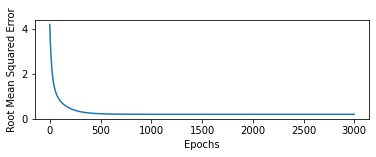

Testing
Testing MSE is  0.16122039513772712
Testing RMSE is  0.40152259604874935


0.40152259604874935

In [ ]:
BestModelRun(GFFSRegressionModel, test_X,train_X)